In [1]:
import imp
from operator import imod
from plt_bulk import bulk_disp
import numpy as np
from collections import deque
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
alat = 14.5533

In [2]:
param = np.zeros(11)
param[0] = 2.0 
param[1] = 2.0 
param[2] = -0.5 
param[3] = -0.15
param[5] = +0.05

param_k = [0.0,0.0, 3.29, 0.57, 0.00, -0.07, 0.19, 0.31, 0.47, 0.0, 0.04]
par_k_dm = param_k.copy()
par_k_dm[4] = 0.07
param_k_noil = param_k[:6] + 5*[0.] 
type(param_k_noil[6:]) ,param_k_noil


(list, [0.0, 0.0, 3.29, 0.57, 0.0, -0.07, 0.0, 0.0, 0.0, 0.0, 0.0])

In [3]:
direct = np.array([[  0.445836 , -0.257404 ,  0.857306],   
                   [ 0.000000  , 0.514807  , 0.857306 ], 
                   [-0.445836  , -0.257404 , 0.857306 ]])

recip = np.array([[ 1.121488, -0.647491,  0.388815],  
                  [ -0.000000,  1.294983, 0.388815],  
                  [ -1.121488, -0.647491,  0.388815]] ) 

In [4]:
inp = {
			 'param':-np.array(param_k), 
			 'S':3.0/2.0}
#
inp_dm = { 'param': -np.array(par_k_dm), 'S':3./2.}
k = np.array([1./3.,-1./3.,0.0])
zs = np.array([0.3333333,0.333333,0.3333333])
gk0 = [bulk_disp(*(c*k+0.5*zs), branch=0,**inp) for c in np.linspace(0.0,1.5,num=120)] 
gk1 = [bulk_disp(*(c*k+0.5*zs), branch=1,**inp) for c in np.linspace(0.0,1.5,num=120)]
gk0dm = [bulk_disp(*(c*k+0.5*zs), branch=0,**inp_dm) for c in np.linspace(0.0,1.5,num=120)] 
gk1dm = [bulk_disp(*(c*k+0.5*zs), branch=1,**inp_dm) for c in np.linspace(0.0,1.5,num=120)]
K = k.dot(recip)
h1 = np.array([1,-1,0]).dot(direct)
a_hex = np.sqrt((h1.dot(h1)))
sk = np.sqrt(K.dot(K))/a_hex
gkascissa = [c*sk for c in np.linspace(0.0,1.5,num=120)]

In [5]:
K = k.dot(recip)  
m1 = np.sqrt(K.dot(K))
Kp = recip[0] -recip[2]
m2 = np.sqrt(Kp.dot(Kp))
Kp/3.0 

array([0.74765867, 0.        , 0.        ])

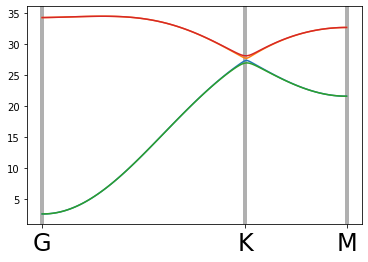

In [6]:
from matplotlib.pyplot import tick_params


plt.plot(gkascissa,gk0)
plt.plot(gkascissa,gk1)
plt.plot(gkascissa,gk0dm)
plt.plot(gkascissa,gk1dm)
plt.grid (visible=True, axis='x')
plt.xticks([0,sk,1.5*sk],['G','K','M'], size=24)
plt.tick_params(grid_linewidth=4)

In [7]:
d = np.array([[0.1,0.0,0.0],[0.0,0.1,0.0],[0.0,0.0,0.1]])
d_frac= direct.T.dot(d)
d_frac[1].dot(recip)

array([ 0.0000000e+00,  9.9999986e-02, -3.8881500e-08])

In [8]:
dodline = lambda dir,branch: [bulk_disp(*(k+c*d_frac[dir]),branch=branch, **inp) for c in np.linspace(-1.0,1.0,21)]
gap = lambda q,inp_: bulk_disp(*q,branch=1,**inp_)-bulk_disp(*q,branch=0, **inp_)
gapline = lambda dir,inp_=inp:[gap(k+c*d_frac[dir] + 0.5 * zs,inp_) for c in np.linspace(-1.0,1.0,21)]

gdx1 = dodline(dir=0,branch=0)
gdx2 = dodline(dir=0,branch=1)
gdy1 = dodline(dir=1,branch=0)
gdy2 = dodline(dir=1,branch=1)
gap1 = gapline(0)


([<matplotlib.axis.XTick at 0x7f1ab9b97370>,
 <a list of 5 Text major ticklabel objects>)

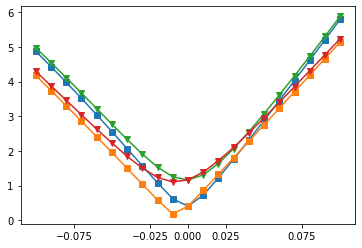

In [9]:
#plt.plot(np.linspace(-1,1,21), gdx2,marker='o')
#plt.plot(np.linspace(-1,1,21), gdx1, marker='o')
#plt.plot(np.linspace(-1,1,21), gdy1, marker='o')
#plt.plot(np.linspace(-1,1,21), gdy2, marker='o')
plt.plot(np.linspace(-1,1,21)*0.1, gapline(0), marker='s')
plt.plot(np.linspace(-1,1,21)*0.1, gapline(1), marker='s')
plt.plot(np.linspace(-1,1,21)*0.1, gapline(0,inp_dm), marker='v')
plt.plot(np.linspace(-1,1,21)*0.1, gapline(1,inp_dm), marker='v')
plt.xticks([-0.075,-0.025,0.0, 0.025, 0.075])

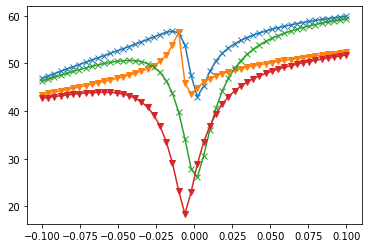

In [10]:
def gap_grad(o, disp, parms, v='bck'):
    direct = np.array([[  0.445836 , -0.257404 ,  0.857306],   
                   [ 0.000000  , 0.514807  , 0.857306 ], 
                   [-0.445836  , -0.257404 , 0.857306 ]])
    dx_frac = direct.T.dot([[disp,0.0,0.0],
                          [0.0,disp,0.0],
                          [0.0,0.0,disp]
                         ])
    gap = lambda q: bulk_disp(*q,branch=1,**parms)-bulk_disp(*q,branch=0, **parms)
    
    go = gap(o)
    if v == 'fw':
        dgx = (gap(o+dx_frac[0])-go)/disp
        dgy = (gap(o+dx_frac[1])-go)/disp
    elif v == 'bck':
        dgx = (go - gap(o-dx_frac[0]))/disp
        dgy = (go - gap(o-dx_frac[1]))/disp
    elif v == 'both':
        dgx = ((gap(o+dx_frac[0])- gap(o-dx_frac[0]))/disp)/2.0
        dgy = ((gap(o+dx_frac[1])- gap(o-dx_frac[1]))/disp)/2.0
    return np.array([dgx,dgy])

g = lambda s,d,par: gap_grad(k+s*d_frac[d]+0.5*zs,0.00001, par, v='bck')
gline = [np.sqrt(g(s,0,inp).dot(g(s,0,inp))) for s in np.linspace(-1.0,1.0,50)]
gline2 = [np.sqrt(g(s,1,inp).dot(g(s,1,inp))) for s in np.linspace(-1.0,1.0,50)]
gline_dm = [np.sqrt(g(s,0,inp).dot(g(s,0,inp_dm))) for s in np.linspace(-1.0,1.0,50)]
gline2_dm = [np.sqrt(g(s,1,inp).dot(g(s,1,inp_dm))) for s in np.linspace(-1.0,1.0,50)]
#
plt.plot(0.1*np.linspace(-1.0,1.0,50), gline,marker='x')
plt.plot(0.1*np.linspace(-1.0,1.0,50), gline2,marker='v')
plt.plot(0.1*np.linspace(-1.0,1.0,50), gline_dm, marker='x')
plt.plot(0.1*np.linspace(-1.0,1.0,50), gline2_dm, marker='v')

In [11]:
def jac(o, disp, parms):
  direct = np.array([[  0.445836 , -0.257404 ,  0.857306],   
                   [ 0.000000  , 0.514807  , 0.857306 ], 
                   [-0.445836  , -0.257404 , 0.857306 ]])
  dx_frac = direct.T.dot([[disp,0.0,0.0],
                          [0.0,disp,0.0],
                          [0.0,0.0,disp]])
  gap = lambda q: bulk_disp(*q,branch=1,**parms)-bulk_disp(*q,branch=0, **parms)
  
  go = gap(o)
  gpx = gap (o + dx_frac[0])
  gmx = gap (o - dx_frac[0])
  gpy = gap (o + dx_frac[1])
  gmy = gap (o - dx_frac[1])
  gpxy = gap (o + dx_frac[0] + dx_frac[1] )
  gmxy = gap (o - dx_frac[0] - dx_frac[1] )
  dxx = (gpx + gmx - 2 * go) / 2 /disp**2 
  dyy = (gpy + gmy - 2 * go) / 2 /disp**2 
  dxy = ((gpxy + go - gpx -gpy))/disp**2 
  return np.array([[dxx,dxy],[dxy,dyy]]) 


In [12]:
def steepest_descent_gap(o, disp,parms, v='bck'):
    direct = np.array([[  0.445836 , -0.257404 ,  0.857306],   
                   [ 0.000000  , 0.514807  , 0.857306 ], 
                   [-0.445836  , -0.257404 , 0.857306 ]])
    #
    gap = lambda q: bulk_disp(*q,branch=1,**parms)-bulk_disp(*q,branch=0, **parms)
    g = gap(o)
    grad = gap_grad(o,disp, parms, v)
    new_q_2D = (-g/grad.dot(grad)) * grad
    new_q_3D = np.array([new_q_2D[0],new_q_2D[1], 0.0])
    new_q_frac = o + direct.dot(new_q_3D)
    return(gap(new_q_frac)) 
    
def newton_scf_gap(o, disp,parms):
    direct = np.array([[  0.445836 , -0.257404 ,  0.857306],   
                   [ 0.000000  , 0.514807  , 0.857306 ], 
                   [-0.445836  , -0.257404 , 0.857306 ]])
    #
    gap = lambda q: bulk_disp(*q,branch=1,**parms)-bulk_disp(*q,branch=0, **parms)
    g = gap(o)
    grad = gap_grad(o,disp, parms, v='both')
    hess = jac(o, disp, parms)
    dr  = (-g/grad.dot(grad)) * grad 
    grad2 = grad + 0.5 *  hess.dot(dr)
    dr2 =  (-g/grad2.dot(grad2)) * grad2  
    grad3 = grad2 + 0.5 * hess.dot(dr2) 
    dr3 = (-g/grad3.dot(grad3))*grad3
    new_q_3D = np.array([dr2[0],dr2[1], 0.0])
    new_q_frac = o + direct.dot(new_q_3D)
    return(gap(new_q_frac)) 

def newton_gap(o, disp,parms):
    direct = np.array([[  0.445836 , -0.257404 ,  0.857306],   
                   [ 0.000000  , 0.514807  , 0.857306 ], 
                   [-0.445836  , -0.257404 , 0.857306 ]])
    #
    gap = lambda q: bulk_disp(*q,branch=1,**parms)-bulk_disp(*q,branch=0, **parms)
    g = gap(o)
    grad = gap_grad(o,disp, parms, v='both')
    hess = jac(o, disp, parms)
    s = grad/np.sqrt(grad.dot(grad)) 
    modgrad = grad.dot(s) 
    d2gds2 = (s.dot(hess)).dot(s)  
    alpha = (-modgrad + np.sqrt(modgrad**2 - 2 * d2gds2 * g))/d2gds2 
    dr2 =  alpha * s 
    new_q_3D = np.array([dr2[0],dr2[1], 0.0])
    new_q_frac = o + direct.dot(new_q_3D)
    return(gap(new_q_frac))

def newton_min_gap(o,disp,parms):
  direct = np.array([[  0.445836 , -0.257404 ,  0.857306],   
                   [ 0.000000  , 0.514807  , 0.857306 ], 
                   [-0.445836  , -0.257404 , 0.857306 ]])
    #
  gap = lambda q: bulk_disp(*q,branch=1,**parms)-bulk_disp(*q,branch=0, **parms)
  g = gap(o)
  grad = gap_grad(o,disp, parms, v='both')
  hess = jac(o, disp, parms)
  hi =np.array(np.matrix(hess).I)
  dr2 = -hi.dot(grad)
  new_q_3D = np.array([dr2[0],dr2[1], 0.0])
  new_q_frac = o + direct.dot(new_q_3D)
  return(gap(new_q_frac)) 

<ipython-input-12-38e2e27bb5b3>:44: RuntimeWarning: invalid value encountered in sqrt
  alpha = (-modgrad + np.sqrt(modgrad**2 - 2 * d2gds2 * g))/d2gds2


(-0.027500000000000004, 0.027500000000000004, -0.026646961446166986, 0.3)

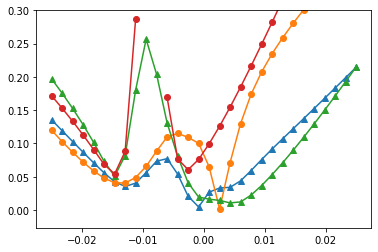

In [13]:
lspace = np.linspace(-.25,0.25,30)
gs = lambda s,d,par:  steepest_descent_gap(k+s*d_frac[d]+0.5*zs,0.001,par,v='both')
gs2 = lambda s,d,par: newton_scf_gap(k+s*d_frac[d]+0.5*zs,0.005,par)
ghs = lambda s,d,par: newton_gap(k+s*d_frac[d]+0.5*zs,0.005,par) 
gsline  = [gs2(s,0,inp) for s in lspace]
ghsline = [ghs(s,0,inp) for s in lspace]
gsline1 = [gs2(s,1,inp) for s in lspace]
ghsline1 = [ghs(s,1,inp) for s in lspace]
gapline = lambda dir,inp_,spc=inp:[gap(k+c*d_frac[dir],inp_) for c in spc]
gaps = gapline(0,inp, lspace)
plt.plot(0.1 * lspace, gsline,marker='^')
plt.plot(0.1*lspace,ghsline, marker='o')
plt.plot(0.1 * lspace, gsline1, marker='^')
plt.plot(0.1 * lspace, ghsline1, marker='o')
_ = plt.axis()
plt.axis([_[0],_[1],_[2],0.3])
#plt.plot(0.1*lspace, gaps, color = 'red')


In [14]:
hess = jac(k,0.001,inp)
grad = gap_grad(k, 0.001,inp, v= 'both')
dr = -gap(k,inp)/grad.dot(grad) *grad 
grad2 = grad +  0.5*hess.dot(dr)
dr2 = -gap(k,inp)/grad2.dot(grad2) *grad2
dr2 = np.array(np.matrix(hess).I.dot(grad))[0]
dr2


array([ 0.04028864, -0.0350011 ])

In [15]:
t = direct.T.dot([[0.1,0.0,0.0],[0.0,0.1,0.0],[0.0,0.0,0.1]])
t

array([[ 0.0445836,  0.       , -0.0445836],
       [-0.0257404,  0.0514807, -0.0257404],
       [ 0.0857306,  0.0857306,  0.0857306]])

In [16]:
t[1].dot(recip[:,1])

0.09999998600090002

In [17]:
v = np.array([0.12,0.21,0.0])
fr = direct.dot(v)
fr[0]*recip[0]+fr[1]*recip[1]+fr[2]*recip[2]

array([ 1.19999934e-01,  2.09999971e-01, -8.16511500e-08])

In [18]:
k_disp = k + direct.dot(np.array([0.01,0,0]))
k_disp, k_disp.dot(recip)-k.dot(recip)


(array([ 0.33779169, -0.33333333, -0.00445836]),
 array([9.99999448e-03, 0.00000000e+00, 5.20417043e-18]))

In [19]:
inp

{'param': array([-0.  , -0.  , -3.29, -0.57, -0.  ,  0.07, -0.19, -0.31, -0.47,
        -0.  , -0.04]),
 'S': 1.5}

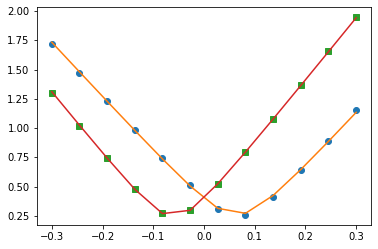

In [209]:
lspace =  np.linspace(-0.3, 0.3, 12) 
def gap_prova(x,k0x, k0y, hxx, hxy, hyy, beta):
  delta_k = x - np.array([k0x,k0y]) 
  h = np.array([[hxx,hxy],[hxy,hyy]])
  if (delta_k.dot(h)).dot(delta_k) + beta > 0.:
    return np.sqrt((delta_k.dot(h)).dot(delta_k) + beta) 
  else:
    return 0
#
def gap_prova_v(xv, k0x, k0y, hxx,hxy,hyy, beta):
  return [gap_prova(_, k0x, k0y, hxx,hxy,hyy, beta) for _ in xv] 
#
kxky_dir = lambda q: q.dot(recip)[0:2]
xdata = [kxky_dir(k+s*d_frac[0]) for s in  lspace] 
xdata2 =[kxky_dir(k+s*d_frac[1]) for s in  lspace]  
ydata = [gap(k+s*d_frac[0],inp) for s in lspace]
ydata2 = [gap(k+s*d_frac[1],inp) for s in lspace]
p = curve_fit(gap_prova_v, xdata,ydata,p0=[k.dot(recip)[0], k.dot(recip)[1],   1,0,1,0],maxfev= 1000, sigma=np.full_like(ydata,0.001))
p2 = curve_fit(gap_prova_v, xdata2,ydata2,p0=[k.dot(recip)[0], k.dot(recip)[1],1,0,1,0], maxfev=1000, sigma=np.full_like(ydata,0.001))
xdata3 = xdata+xdata2 
ydata3 = ydata+ydata2
p3 = curve_fit(gap_prova_v, xdata3,ydata3,p0=[k.dot(recip)[0], k.dot(recip)[1],1,0,1,0], maxfev=1000, sigma=np.full_like(ydata3,0.001))
fitted = [gap_prova(x_,*p3[0]) for x_ in xdata]
fitted2 = [gap_prova(x_,*p3[0]) for x_ in xdata2]
plt.plot(lspace, ydata, 'o')
plt.plot(lspace,fitted)
plt.plot(lspace, ydata2,'s')
plt.plot(lspace, fitted2)


In [210]:
p[0],p2[0],p3[0],k.dot(recip)[0:2]

(array([3.70640366e-01, 4.48205787e-01, 2.21549811e+03, 1.94867633e+01,
        7.65527688e-02, 1.78688675e-01]),
 array([ 1.01497400e+00, -6.50094412e-01,  2.39668079e-01, -1.51910833e+01,
         2.86833415e+03, -3.67833509e-03]),
 array([ 3.79939084e-01, -6.53134486e-01,  2.20819324e+03, -1.49541469e+02,
         2.87605255e+03, -2.34473284e-02]),
 array([ 0.37382933, -0.64749133]))

In [208]:
p3[1]

array([[ 2.80631867e+04, -2.10856131e+04,  1.45625832e+03,
         1.57729185e+10, -1.12756467e+03, -7.62359172e+05],
       [-2.10856131e+04,  1.58429291e+04, -1.09417722e+03,
        -1.18511721e+10,  8.47209294e+02,  5.72807738e+05],
       [ 1.45625832e+03, -1.09417722e+03,  5.36308517e+02,
         8.18490352e+08, -2.38173928e+00, -3.95604732e+04],
       [ 1.57729185e+10, -1.18511721e+10,  8.18490353e+08,
         8.86517133e+15, -6.33747764e+08, -4.28484092e+11],
       [-1.12756467e+03,  8.47209294e+02, -2.38173928e+00,
        -6.33747764e+08,  6.20438165e+02,  3.06311663e+04],
       [-7.62359172e+05,  5.72807738e+05, -3.95604732e+04,
        -4.28484092e+11,  3.06311663e+04,  2.07101037e+07]])

In [152]:
ytot = ydata+ydata2 
xtot = xdata+xdata2

In [153]:
len(xtot)

40